In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.pyplot as plot
%matplotlib inline
import math 
import cv2 
from glob import glob 
import itertools 
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,CSVLogger
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
plot.style.use('ggplot')

In [4]:
scale = 70 
seed = 7

In [5]:
path_to_images = 'hymenoptera/train/*/*.jpg'
images = glob(path_to_images)
trainingset = []
traininglabels = []
num = len(images)
count = 1
for i in images:
    print(str(count)+'/'+str(num),end='\r')
    trainingset.append(cv2.resize(cv2.imread(i),(scale,scale)))
    traininglabels.append(i.split('/')[-2])
    count=count+1
trainingset = np.asarray(trainingset) 
traininglabels = pd.DataFrame(traininglabels) 


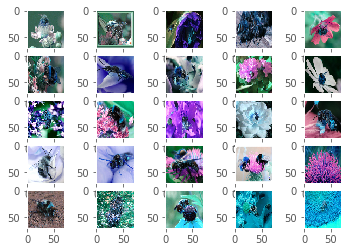

In [8]:
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(trainingset[i])
    plt.grid(False)

Classes: ['ants' 'bees']
Number of classes: 2


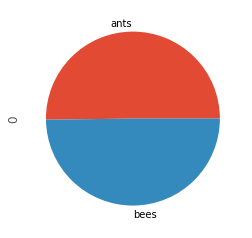

In [9]:
labels = preprocessing.LabelEncoder()
labels.fit(traininglabels[0])
print('Classes: '+str(labels.classes_))
encodedlabels = labels.transform(traininglabels[0])
clearalllabels = np_utils.to_categorical(encodedlabels)
classes = clearalllabels.shape[1]
print("Number of classes: " + str(classes))
traininglabels[0].value_counts().plot(kind='pie')

In [10]:
new_train = trainingset/255 
x_train,x_test,y_train,y_test = train_test_split(new_train,
               clearalllabels,test_size=0.1,
               random_state=seed,stratify=clearalllabels)
print('Train Shape: {}'.format(x_train.shape))

Train Shape: (218, 70, 70, 3)


In [11]:
generator = ImageDataGenerator(
    rotation_range = 180, 
    zoom_range = 0.1, 
    width_shift_range = 0.1,  
    height_shift_range = 0.1,  
    horizontal_flip = True,  
    vertical_flip = True  
)
generator.fit(x_train)

In [12]:
np.random.seed(seed)
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(5, 5),
                 input_shape=(scale, scale, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(classes, activation='softmax'))

In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 66, 66, 64)        4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 66, 66, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 31, 31, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 128)       204928    
__________

In [14]:
lrr = ReduceLROnPlateau(monitor='val_acc', patience=3,  verbose=1,
                        factor=0.4,  min_lr=0.00001)

In [15]:
filepath='weights.best_{epoch:02d}-{val_acc:.2f}.h5'
checkpoints = ModelCheckpoint(filepath, monitor='val_acc', 
                              verbose=1, save_best_only=True, mode='max')
filepath='weights.last_auto4.h5'
checkpoints_full = ModelCheckpoint(filepath, monitor='val_acc', 
                                 verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoints, lrr, checkpoints_full]

In [16]:
nepochs=20
hist = model.fit_generator(generator.flow(x_train, y_train, batch_size=75),
                            epochs=nepochs, validation_data=(x_test, y_test),
                            steps_per_epoch=x_train.shape[0], callbacks=callbacks_list)

Epoch 1/20
218/218 [==============================] - 226s 1s/step - loss: 0.6103 - acc: 0.7230 - val_loss: 1.3037 - val_acc: 0.6800

Epoch 00001: val_acc improved from -inf to 0.68000, saving model to weights.best_01-0.68.h5

Epoch 00001: saving model to weights.last_auto4.h5
Epoch 2/20
218/218 [==============================] - 204s 937ms/step - loss: 0.2489 - acc: 0.8951 - val_loss: 0.8872 - val_acc: 0.7600

Epoch 00002: val_acc improved from 0.68000 to 0.76000, saving model to weights.best_02-0.76.h5

Epoch 00002: saving model to weights.last_auto4.h5
Epoch 3/20
218/218 [==============================] - 204s 938ms/step - loss: 0.1507 - acc: 0.9426 - val_loss: 1.0835 - val_acc: 0.7600

Epoch 00003: val_acc did not improve from 0.76000

Epoch 00003: saving model to weights.last_auto4.h5
Epoch 4/20
218/218 [==============================] - 204s 938ms/step - loss: 0.1085 - acc: 0.9598 - val_loss: 1.7950 - val_acc: 0.6400

Epoch 00004: val_acc did not improve from 0.76000

Epoch 00004

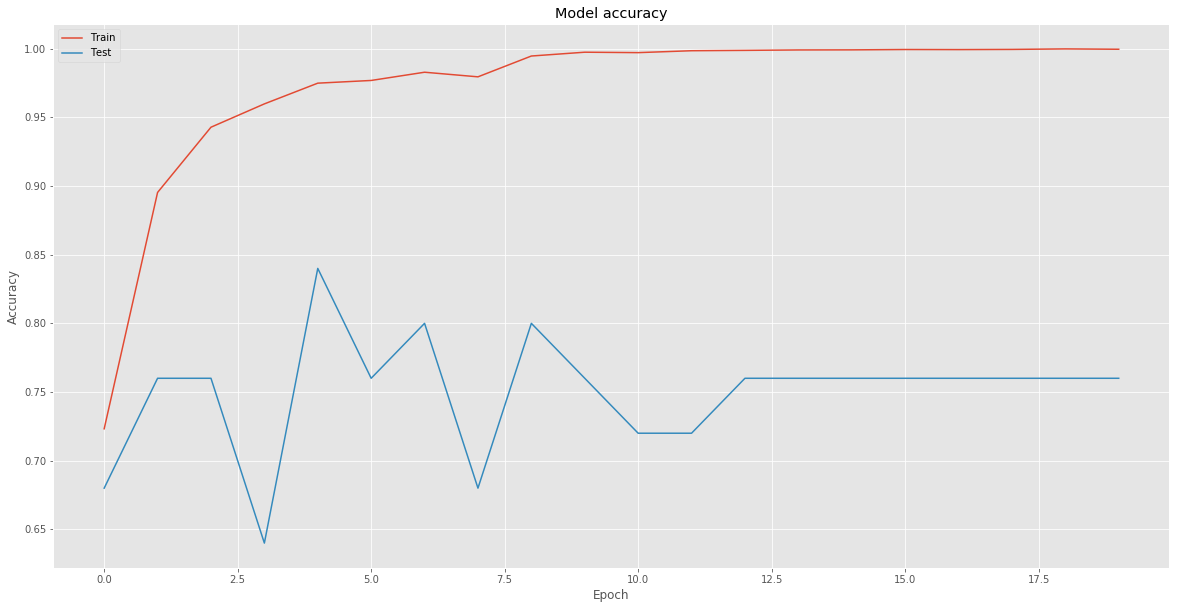

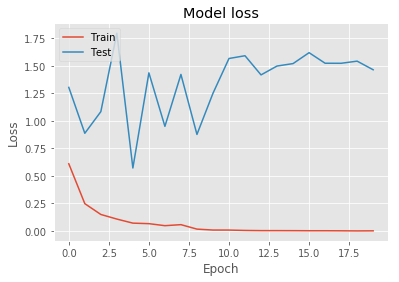

In [18]:
plt.figure(figsize=(20,10))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
####
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [19]:
model.load_weights("weights.last_auto4.h5") 
print(model.evaluate(x_train, y_train))  
print(model.evaluate(x_test, y_test))  

218/218 [==============================] - 3s 14ms/step
[0.00024719579245974184, 1.0]
25/25 [==============================] - 0s 5ms/step
[1.4635610580444336, 0.7599999904632568]


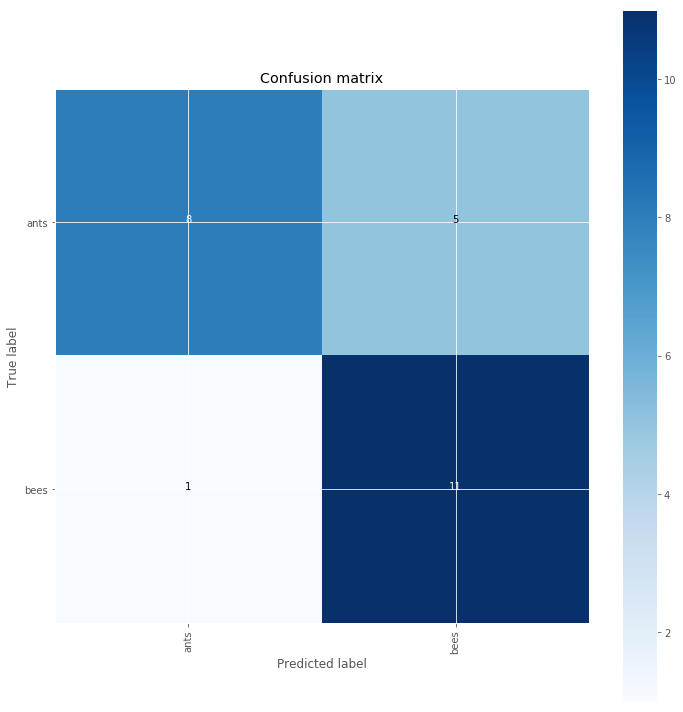

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

predY = model.predict(x_test)
predYClasses = np.argmax(predY, axis = 1) 
trueY = np.argmax(y_test, axis = 1) 
confusionMTX = confusion_matrix(trueY, predYClasses) 
plot_confusion_matrix(confusionMTX, classes = labels.classes_)

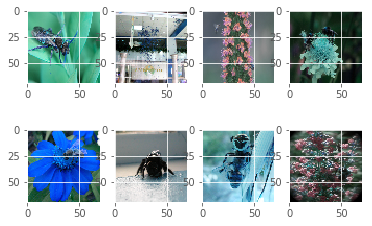

In [25]:
path_to_test = 'hymenoptera/val/*/*.jpg'
pics = glob(path_to_test)
testimages = []
tests = []
count=1
num = len(pics)
for i in pics:
    print(str(count)+'/'+str(num),end='\r')
    tests.append(i.split('/')[-1]) 
    testimages.append(cv2.resize(cv2.imread(i),(scale,scale)))
    count = count + 1
testimages = np.asarray(testimages)
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(testimages[i])

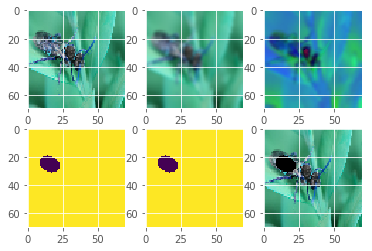

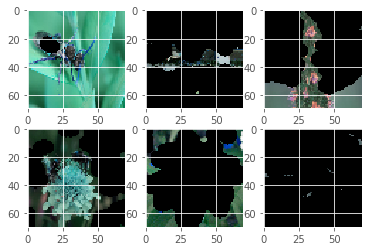

In [26]:
newtestimages = []
sets = []
getEx = True
for i in testimages:
    blurr = cv2.GaussianBlur(i,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
    lower = (25,40,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    masking = np.zeros_like(i,np.uint8) 
    masking[boolean] = i[boolean] 
    newtestimages.append(masking)
    if getEx:
        plt.subplot(2,3,1);plt.imshow(i) 
        plt.subplot(2,3,2);plt.imshow(blurr)
        plt.subplot(2,3,3);plt.imshow(hsv) 
        plt.subplot(2,3,4);plt.imshow(mask) 
        plt.subplot(2,3,5);plt.imshow(boolean) 
        plt.subplot(2,3,6);plt.imshow(masking) 
        plt.show()
        getEx=False
newtestimages = np.asarray(newtestimages)
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(newtestimages[i])

In [27]:
newtestimages=newtestimages/255
prediction = model.predict(newtestimages)
pred = np.argmax(prediction,axis=1)
predStr = labels.classes_[pred]
result = {'file':tests,'species':predStr}
result = pd.DataFrame(result)
result.to_csv("Prediction.csv",index=False)
print('Prediction result saved as Prediction.csv')

Prediction result saved as Prediction.csv
